# 06 预训练词向量及其应用

本 Notebook 中，我们将介绍预训练词向量的概念，并将其应用到前面实现的各类模型中，以提升模型的性能。

## 6.1 词向量回顾

在 `05Implement.ipynb` 中，我们构建了几种机器学习模型，并通过训练、验证与测试，完成了文本情感分类问题。

我们实现的神经网络框架，包括 MLP、CNN、LSTM 以及 Transformer，其中都包括一个必不可少的组成部分——**词向量层**（Embedding Layer）。

回顾一下，词向量层的主要作用是将离散的词元映射到连续的向量空间中，从而使得模型能够更好地捕捉词与词之间的语义关系。

一般来说，词向量表示中的向量值是随着目标任务的优化过程自动调整的，即将词向量中的向量值看做模型的参数。

## 6.2 预训练词向量

在 `05Implement.ipynb` 的实现中，我们使用了随机初始化的词向量，这意味着词向量的初始值是随机生成的，然后在训练过程中根据任务的损失函数进行调整。

这意味着，词向量在训练开始时并没有任何语义信息，而是通过大量的训练数据逐渐学习到词与词之间的关系。这种方法虽然有效，但无疑需要大量的训练数据和时间。

于是，我们引入了 **预训练词向量**（Pre-trained Word Embeddings）的概念。预训练词向量是指在大规模语料库上预先训练好的词向量表示，这些词向量已经捕捉了丰富的语义信息。

通过使用预训练词向量，我们可以在特定任务上获得更好的性能，尤其是在训练数据有限的情况下。

按照词向量表示与上下文的相关性，预训练词向量可以分为两大类：

1. **静态词向量（Static Word Embeddings）**：每个词元对应一个固定的向量表示，独立于上下文。常用的静态词向量模型包括 Word2Vec、GloVe 和 FastText 等。

2. **动态词向量（Dynamic Word Embeddings）**：词元的向量表示会根据其在句子中的上下文而变化。常用的动态词向量模型包括 ELMo 等。

为了更形象地理解二者的区别，我们来看下面的例子：

> 句子 1：他 亲自 <u>下场</u> 参加 比赛

> 句子 2：竟 落得 这样 的 <u>下场</u>

显然，句子 1 和句子 2 中共同出现的“<u>下场</u>”一词的词义截然不同，并且具有不同的词性。

在静态词向量模型中，“<u>下场</u>”一词无论出现在句子 1 还是句子 2 中，其对应的词向量表示都是相同的，因为静态词向量不考虑上下文信息；

而对于动态词向量模型而言，“<u>下场</u>”一词的词向量表示会根据其所在句子的上下文而变化，从而针对两种不同的语境，得到两个不同的词向量表示，提高了模型对词义的理解能力。

关于预训练词向量的模型构建与训练方法，并不是本项目的重点内容。感兴趣的读者可以参考相关文献和教程进行深入学习。

在本 Notebook 中，我们主要应用静态词向量作为初始化的模型参数，将其集成到深度学习模型中，并在下游任务（即文本情感分类任务）的训练过程中，通过反向传播调整词向量层的参数，这一过程又被称为 **精调**（Fine-tuning）。

## 6.3 导入模块并加载数据

无论使用预训练词向量与否，对模型的训练、验证与测试流程都是相同的。因此，我们可以直接复用 `05Implement.ipynb` 中的通用代码，以及各类模型的定义和相关代码。

然后，加载数据和词汇表。

In [ ]:
import torch.nn as nn

from torch.utils.data import DataLoader

from MyModule import (
    load_data, 
    load_vocab, 
    class_weights, 
    train_model_with_validation, 
    test_model_comprehensive, 
    plot_training_curves,
    print_training_summary,
    save_training_results,
    BowDataset, 
)


train_data = load_data("data/final/train_index.txt", sep=",", is_indexed=True)
val_data = load_data("data/final/val_index.txt", sep=",", is_indexed=True)
test_data = load_data("data/final/test_index.txt", sep=",", is_indexed=True)

# 加载数据
train_dataset = BowDataset(train_data)
val_dataset = BowDataset(val_data)
test_dataset = BowDataset(test_data)

vocab = load_vocab("data/final/vocab.txt")

## 6.4 预训练词向量的集成

### 6.4.1 预训练词向量的选择

网络上有许多公开的预训练词向量资源可供下载和使用。这里，我们使用腾讯 AI Lab 提供的中文预训练词向量。

腾讯 AI Lab 中文词向量的原版有约 1200 万个中文词汇和短语，词向量的维度为 200 维，文本文件总大小约 15 GB。

我们使用其缩小版本，预训练词向量采用文本文件格式存储，文本文件大小约 190 MB，其中包含约 10 万个常用中文词汇和短语，词向量的维度仍为 200 维。

可以从以下链接下载该缩小版本以及其他大小版本的预训练词向量文件：https://github.com/cliuxinxin/TX-WORD2VEC-SMALL

这里已经事先将预训练词向量文件下载至本地，见本项目目录下 `resources/Word2Vec-100000-small.txt`。

打开预训练词向量文件后，可以看到如下格式的内容：

可以看到，预训练词向量的基本格式是：
- 每一行表示一个词元及其对应的词向量表示；
- 每一行的第一个元素是词元，后续的元素是该词元对应的词向量表示，各个词向量值之间以空格分隔。每个词向量的维度为200维。

据此，我们可以编写代码，读入预训练词向量。

### 6.4.2 预训练词向量矩阵

那么，如何将得到的预训练词向量集成到深度学习模型中呢？

首先，我们需要构建一个预训练词向量矩阵。方法如下：
- 随机初始化一个形状为 `(vocab_size, embedding_dim)` 的矩阵 `embeddings`，其中 `vocab_size` 是词汇表的大小，`embedding_dim` 是词向量的维度
- 遍历预训练词向量文件中的每一行，提取词元和对应的词向量表示
- 如果词元在词汇表中存在，则用该词元对应的词向量表示替换到 `embeddings` 矩阵中对应的行

这样，当预训练词向量文件遍历结束后，`embeddings` 矩阵就包含了词汇表中所有词元的词向量表示，其中未在预训练词向量文件中出现的词元仍然保持随机初始化的向量表示。

In [2]:
import numpy as np
import torch

def load_pretrained_embeddings(embedding_path, vocab, embedding_dim=200):
    """根据已有 vocab 构建向量矩阵"""
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))  # 随机初始化
    with open(embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            if word in vocab.token_to_idx:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

embedding_matrix = load_pretrained_embeddings("resources/Word2Vec-100000-small.txt", vocab, embedding_dim=200)

### 6.4.3 集成预训练词向量到模型中

获得词向量矩阵 `embedding_matrix` 后，如何将其集成到模型中呢？

方法很简单，只需要将 `embedding_matrix` 矩阵作为参数传递给模型类的 `from_pretrained()` 方法即可。

例如，可以按如下方式将其集成到 MLP 模型中：

```python
class MLP(nn.Module):
    def __init__(self, vocab_size, ..., 
                 pretrained_embedding_matrix=None, freeze=True):
        super(MLP, self).__init__()

        # EmbeddingBag 层
        self.embeddingbag = nn.EmbeddingBag.from_pretrained(
            pretrained_embedding_matrix, 
            freeze=freeze
            )

        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(...)
```

注意到 `from_pretrained()` 方法中还有一个 `freeze` 参数，用于指定是否在训练过程中冻结词向量层的参数。

- 如果 `freeze=True`，则表示在训练过程中不更新词向量层的参数，即保持预训练词向量不变；

- 如果 `freeze=False`，则表示在训练过程中允许更新词向量层的参数，从而使模型能够根据特定任务的需求对词向量进行微调。

这里，我们将 `freeze` 参数设置为 `False`，以便在文本情感分类任务中对预训练词向量进行微调，从而提升模型的性能。

### 6.4.4 传参注意事项

最后，还有很重要的一点。

我们设置了 `freeze=False`，这意味着训练过程中允许更新词向量层的参数，即词向量矩阵会在模型训练过程中发生变化。

因此，在构造模型时，不能直接将 `embedding_matrix` 传递给 `from_pretrained()` 方法，而应该传入 `embedding_matrix.clone().detach()`，其中：
- `clone()` 方法用于创建 `embedding_matrix` 的一个副本，确保在训练过程中对词向量矩阵的修改不会影响原始矩阵。
- `detach()` 方法用于将该副本从计算图中分离出来，防止梯度回传到原始矩阵，从而避免对原始矩阵的影响。

## 6.5 模型集成、训练与测试

在上一部分，我们已经完整介绍了预训练词向量矩阵的构建方法及集成于模型的方法。

接下来就是将预训练词向量集成到各类模型中，并在文本情感分类任务中进行训练与测试。

除多传入了预训练词向量矩阵参数外，其余代码均与 `05Implement.ipynb` 中的实现相同，因此不再用文字赘述。

### 6.5.1 多层感知机（集成预训练词向量）

In [4]:
from MyModule import MLP, collate_fn_mlp

# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10


train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_pre_emb = MLP(len(vocab), embedding_dim, hidden_dim, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
mlp_pre_emb.to(device)

MLP(
  (embeddingbag): EmbeddingBag(39768, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(mlp_pre_emb.parameters(), lr=0.001)

mlp_history = train_model_with_validation(
    model=mlp_pre_emb,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)


Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.6562	Train Accuracy: 0.7031
    Valid Loss: 0.5951	Valid Accuracy: 0.7320
    Valid Precision: 0.7337	Valid Recall: 0.7320	Valid F1: 0.7255
    ✓ New best validation loss: 0.5951
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.5487	Train Accuracy: 0.7611
    Valid Loss: 0.5897	Valid Accuracy: 0.7361
    Valid Precision: 0.7399	Valid Recall: 0.7361	Valid F1: 0.7290
    ✓ New best validation loss: 0.5897
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.4946	Train Accuracy: 0.7868
    Valid Loss: 0.5931	Valid Accuracy: 0.7461
    Valid Precision: 0.7447	Valid Recall: 0.7461	Valid F1: 0.7424
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.4538	Train Accuracy: 0.8062
    Valid Loss: 0.6067	Valid Accuracy: 0.7481
    Valid Precision: 0.7457	Valid Recall: 0.7481	Valid F1: 0.7441
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.4170	Train Accuracy: 0.8240
    Valid Loss: 0.6327	Valid Accuracy: 0.7433
    Valid Precision: 0.7431	Valid Recall: 0.7433	Valid F1: 0.7406
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5897


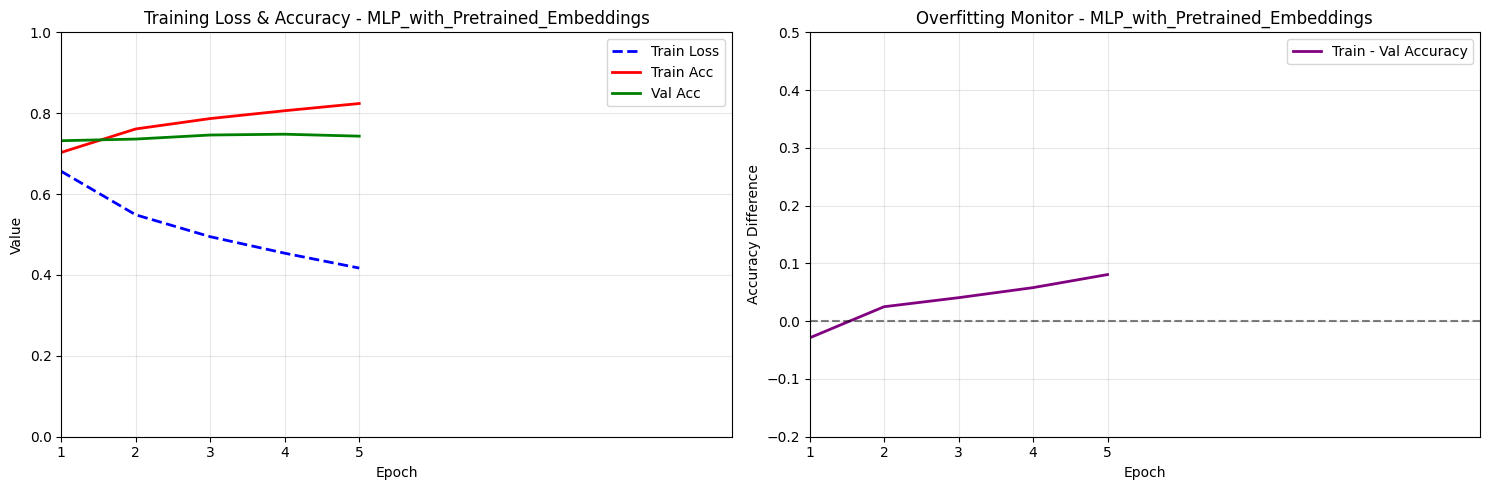


TRAINING SUMMARY
Model Name: MLP_with_Pretrained_Embeddings
Final Train Loss: 0.4170
Final Train Accuracy: 0.8240
Final Val Loss: 0.6327
Final Val Accuracy: 0.7433
Best Val Accuracy: 0.7481 (Epoch 4)
Final Overfitting Gap: 0.0807


In [5]:
# 绘制训练曲线
plot_training_curves("MLP_with_Pretrained_Embeddings", mlp_history)

# 打印训练摘要
print_training_summary("MLP_with_Pretrained_Embeddings", mlp_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: MLP_with_pretrained_embeddings
Test Accuracy: 0.7354
Test Precision (weighted): 0.7396
Test Recall (weighted): 0.7354
Test F1 Score (weighted): 0.7286

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8038    0.7026    0.7498     18608
     Neutral     0.7136    0.5240    0.6043     14723
    Positive     0.7074    0.8833    0.7856     25155

    accuracy                         0.7354     58486
   macro avg     0.7416    0.7033    0.7132     58486
weighted avg     0.7396    0.7354    0.7286     58486



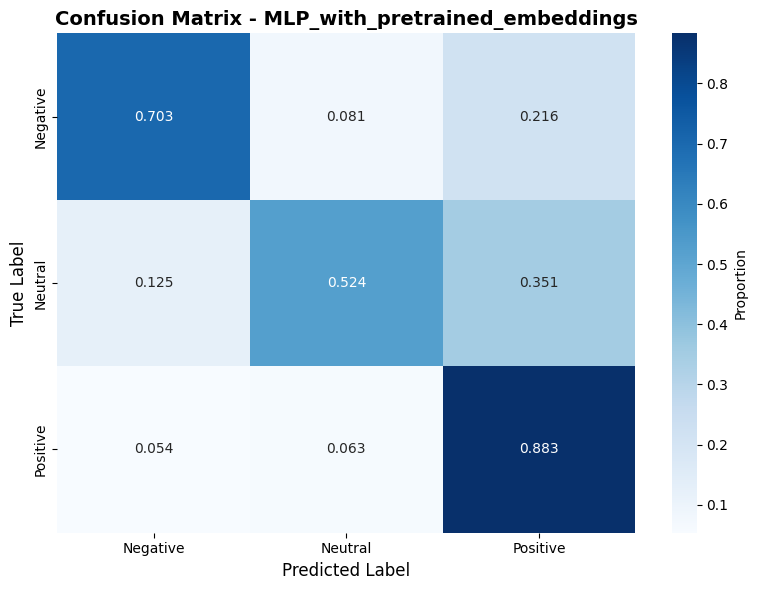


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8038, Recall=0.7026, F1=0.7498, Support=18608
 Neutral: Precision=0.7136, Recall=0.5240, F1=0.6043, Support=14723
Positive: Precision=0.7074, Recall=0.8833, F1=0.7856, Support=25155


In [6]:
mlp_test_results = test_model_comprehensive(
    model=mlp_pre_emb,
    model_name="MLP_with_pretrained_embeddings",
    test_loader=test_data_loader_mlp,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [7]:
# 保存MLP训练结果
save_training_results(
    model=mlp_pre_emb,
    model_name="MLP with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=mlp_history,
    test_results=mlp_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: MLP with Pretrained Embeddings (MLP)
  - 实际训练轮数: 5
  - 测试准确率: 0.7354
  - 测试F1分数: 0.7286
  - 记录时间: 2025-11-25 19:43:55
  - 总记录数: 45


### 6.5.2 卷积神经网络（集成预训练词向量）

In [8]:
from MyModule import CNN, collate_fn_cnn

train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_pre_emb = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
cnn_pre_emb.to(device)

CNN(
  (embedding): Embedding(39768, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [9]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(cnn_pre_emb.parameters(), lr=0.001)

cnn_history = train_model_with_validation(
    model=cnn_pre_emb,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.6249	Train Accuracy: 0.7174
    Valid Loss: 0.6033	Valid Accuracy: 0.7327
    Valid Precision: 0.7399	Valid Recall: 0.7327	Valid F1: 0.7219
    ✓ New best validation loss: 0.6033
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.5297	Train Accuracy: 0.7691
    Valid Loss: 0.5879	Valid Accuracy: 0.7387
    Valid Precision: 0.7451	Valid Recall: 0.7387	Valid F1: 0.7315
    ✓ New best validation loss: 0.5879
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.4792	Train Accuracy: 0.7954
    Valid Loss: 0.5954	Valid Accuracy: 0.7420
    Valid Precision: 0.7557	Valid Recall: 0.7420	Valid F1: 0.7452
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.4356	Train Accuracy: 0.8169
    Valid Loss: 0.5810	Valid Accuracy: 0.7504
    Valid Precision: 0.7477	Valid Recall: 0.7504	Valid F1: 0.7466
    ✓ New best validation loss: 0.5810
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.3998	Train Accuracy: 0.8332
    Valid Loss: 0.6058	Valid Accuracy: 0.7289
    Valid Precision: 0.7439	Valid Recall: 0.7289	Valid F1: 0.7291
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.3662	Train Accuracy: 0.8486
    Valid Loss: 0.6194	Valid Accuracy: 0.7349
    Valid Precision: 0.7423	Valid Recall: 0.7349	Valid F1: 0.7360
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 7/10
    Train Loss: 0.3380	Train Accuracy: 0.8611
    Valid Loss: 0.6655	Valid Accuracy: 0.7196
    Valid Precision: 0.7405	Valid Recall: 0.7196	Valid F1: 0.7220
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5810


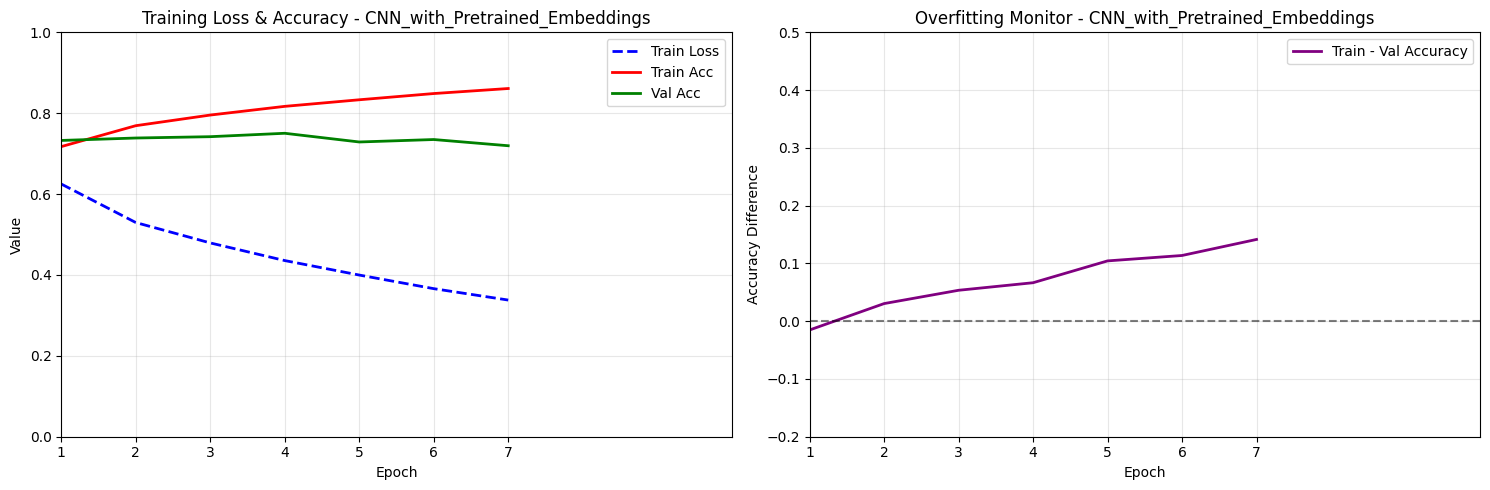


TRAINING SUMMARY
Model Name: CNN_with_Pretrained_Embeddings
Final Train Loss: 0.3380
Final Train Accuracy: 0.8611
Final Val Loss: 0.6655
Final Val Accuracy: 0.7196
Best Val Accuracy: 0.7504 (Epoch 4)
Final Overfitting Gap: 0.1415


In [10]:
# 绘制训练曲线
plot_training_curves("CNN_with_Pretrained_Embeddings", cnn_history)

# 打印训练摘要
print_training_summary("CNN_with_Pretrained_Embeddings", cnn_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: CNN with Pretrained Embeddings
Test Accuracy: 0.7450
Test Precision (weighted): 0.7415
Test Recall (weighted): 0.7450
Test F1 Score (weighted): 0.7388

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7716    0.7707    0.7712     18608
     Neutral     0.6921    0.5242    0.5966     14723
    Positive     0.7482    0.8551    0.7981     25155

    accuracy                         0.7450     58486
   macro avg     0.7373    0.7167    0.7220     58486
weighted avg     0.7415    0.7450    0.7388     58486



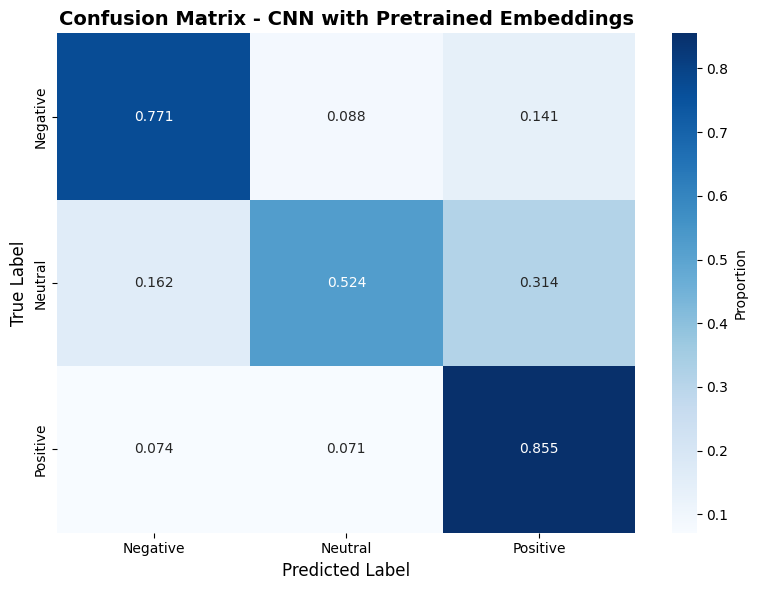


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7716, Recall=0.7707, F1=0.7712, Support=18608
 Neutral: Precision=0.6921, Recall=0.5242, F1=0.5966, Support=14723
Positive: Precision=0.7482, Recall=0.8551, F1=0.7981, Support=25155


In [11]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    test_loader=test_data_loader_cnn,
    device=device
)

In [12]:
# 保存CNN训练结果
save_training_results(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=cnn_history,
    test_results=cnn_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: CNN with Pretrained Embeddings (CNN)
  - 实际训练轮数: 7
  - 测试准确率: 0.7450
  - 测试F1分数: 0.7388
  - 记录时间: 2025-11-25 19:50:09
  - 总记录数: 46


### 6.5.3 长短期记忆网络（集成预训练词向量）

In [13]:
from MyModule import LSTM, collate_fn_lstm

train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pre_emb = LSTM(len(vocab), embedding_dim, hidden_dim, num_class, 
                    embedding_matrix.clone().detach(), freeze=False)
lstm_pre_emb.to(device)

LSTM(
  (embeddings): Embedding(39768, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [14]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(lstm_pre_emb.parameters(), lr=0.001)

lstm_history = train_model_with_validation(
    model=lstm_pre_emb,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
    )

Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.6105	Train Accuracy: 0.7265
    Valid Loss: 0.5500	Valid Accuracy: 0.7561
    Valid Precision: 0.7554	Valid Recall: 0.7561	Valid F1: 0.7540
    ✓ New best validation loss: 0.5500
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.4868	Train Accuracy: 0.7901
    Valid Loss: 0.5423	Valid Accuracy: 0.7621
    Valid Precision: 0.7609	Valid Recall: 0.7621	Valid F1: 0.7573
    ✓ New best validation loss: 0.5423
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.4050	Train Accuracy: 0.8284
    Valid Loss: 0.5573	Valid Accuracy: 0.7631
    Valid Precision: 0.7632	Valid Recall: 0.7631	Valid F1: 0.7626
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.3266	Train Accuracy: 0.8635
    Valid Loss: 0.6153	Valid Accuracy: 0.7573
    Valid Precision: 0.7595	Valid Recall: 0.7573	Valid F1: 0.7577
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.2595	Train Accuracy: 0.8927
    Valid Loss: 0.7313	Valid Accuracy: 0.7513
    Valid Precision: 0.7539	Valid Recall: 0.7513	Valid F1: 0.7517
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5423


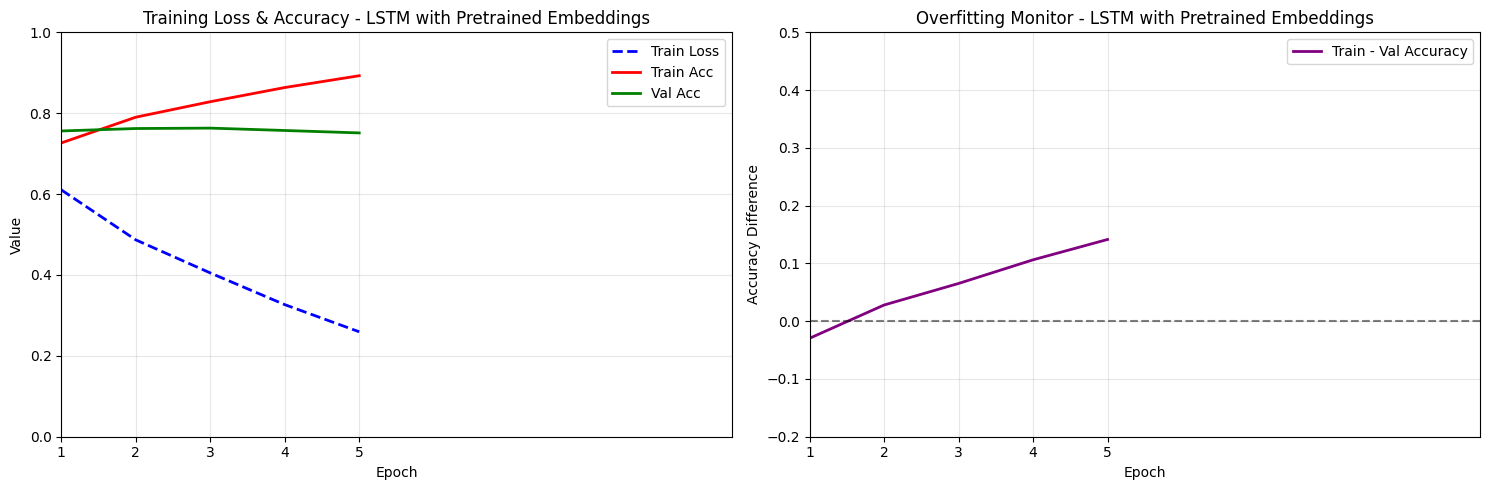


TRAINING SUMMARY
Model Name: LSTM with Pretrained Embeddings
Final Train Loss: 0.2595
Final Train Accuracy: 0.8927
Final Val Loss: 0.7313
Final Val Accuracy: 0.7513
Best Val Accuracy: 0.7631 (Epoch 3)
Final Overfitting Gap: 0.1414


In [15]:
# 绘制训练曲线
plot_training_curves("LSTM with Pretrained Embeddings", lstm_history)

# 打印训练摘要
print_training_summary("LSTM with Pretrained Embeddings", lstm_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: LSTM with Pretrained Embeddings
Test Accuracy: 0.7640
Test Precision (weighted): 0.7628
Test Recall (weighted): 0.7640
Test F1 Score (weighted): 0.7595

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8070    0.7658    0.7859     18608
     Neutral     0.7164    0.5740    0.6373     14723
    Positive     0.7573    0.8739    0.8114     25155

    accuracy                         0.7640     58486
   macro avg     0.7602    0.7379    0.7449     58486
weighted avg     0.7628    0.7640    0.7595     58486



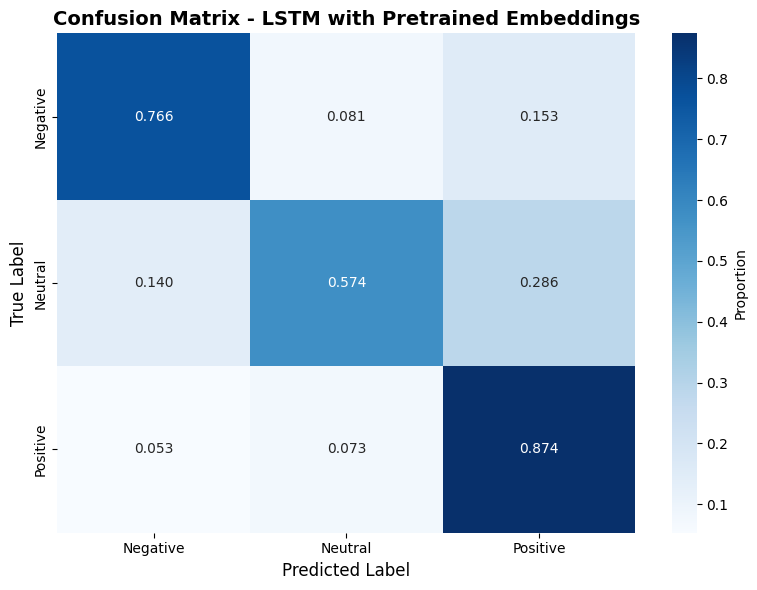


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8070, Recall=0.7658, F1=0.7859, Support=18608
 Neutral: Precision=0.7164, Recall=0.5740, F1=0.6373, Support=14723
Positive: Precision=0.7573, Recall=0.8739, F1=0.8114, Support=25155


In [16]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [17]:
# 保存LSTM训练结果
save_training_results(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=lstm_history,
    test_results=lstm_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: LSTM with Pretrained Embeddings (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7640
  - 测试F1分数: 0.7595
  - 记录时间: 2025-11-25 19:57:13
  - 总记录数: 47


### 6.5.4 Transformer（集成预训练词向量）

In [5]:
from MyModule import Transformer, collate_fn_trans

train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_pre_emb = Transformer(len(vocab), embedding_dim, num_class, 
                                  pretrained_embedding_matrix=embedding_matrix.clone().detach(), 
                                  freeze=False)
transformer_pre_emb.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(39768, 200)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [6]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
# optimizer = torch.optim.Adam(transformer_pre_emb.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(transformer_pre_emb.parameters(), lr=2e-5, weight_decay=1e-3)

transformer_history = train_model_with_validation(
    model=transformer_pre_emb,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 1/10
    Train Loss: 0.8116	Train Accuracy: 0.5992
    Valid Loss: 0.6850	Valid Accuracy: 0.6823
    Valid Precision: 0.6862	Valid Recall: 0.6823	Valid F1: 0.6708
    ✓ New best validation loss: 0.6850
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.7064	Train Accuracy: 0.6736
    Valid Loss: 0.6502	Valid Accuracy: 0.7100
    Valid Precision: 0.7062	Valid Recall: 0.7100	Valid F1: 0.7038
    ✓ New best validation loss: 0.6502
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.6744	Train Accuracy: 0.6927
    Valid Loss: 0.6318	Valid Accuracy: 0.7147
    Valid Precision: 0.7138	Valid Recall: 0.7147	Valid F1: 0.7084
    ✓ New best validation loss: 0.6318
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.6526	Train Accuracy: 0.7048
    Valid Loss: 0.6304	Valid Accuracy: 0.7274
    Valid Precision: 0.7255	Valid Recall: 0.7274	Valid F1: 0.7259
    ✓ New best validation loss: 0.6304
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.6362	Train Accuracy: 0.7123
    Valid Loss: 0.6131	Valid Accuracy: 0.7310
    Valid Precision: 0.7278	Valid Recall: 0.7310	Valid F1: 0.7261
    ✓ New best validation loss: 0.6131
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.6229	Train Accuracy: 0.7190
    Valid Loss: 0.6083	Valid Accuracy: 0.7312
    Valid Precision: 0.7291	Valid Recall: 0.7312	Valid F1: 0.7245
    ✓ New best validation loss: 0.6083
--------------------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 7/10
    Train Loss: 0.6122	Train Accuracy: 0.7255
    Valid Loss: 0.5969	Valid Accuracy: 0.7348
    Valid Precision: 0.7337	Valid Recall: 0.7348	Valid F1: 0.7329
    ✓ New best validation loss: 0.5969
--------------------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 8/10
    Train Loss: 0.6037	Train Accuracy: 0.7289
    Valid Loss: 0.5934	Valid Accuracy: 0.7377
    Valid Precision: 0.7355	Valid Recall: 0.7377	Valid F1: 0.7337
    ✓ New best validation loss: 0.5934
--------------------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 9/10
    Train Loss: 0.5942	Train Accuracy: 0.7343
    Valid Loss: 0.5890	Valid Accuracy: 0.7379
    Valid Precision: 0.7363	Valid Recall: 0.7379	Valid F1: 0.7355
    ✓ New best validation loss: 0.5890
--------------------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 10/10
    Train Loss: 0.5859	Train Accuracy: 0.7369
    Valid Loss: 0.6025	Valid Accuracy: 0.7417
    Valid Precision: 0.7400	Valid Recall: 0.7417	Valid F1: 0.7376
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7183    0.8128    0.7626     18609
     Neutral     0.7010    0.5519    0.6176     14746
    Positive     0.7790    0.8002    0.7895     25154

    accuracy                         0.7417     58509
   macro avg     0.7328    0.7217    0.7232     58509
weighted avg     0.7400    0.7417    0.7376     58509



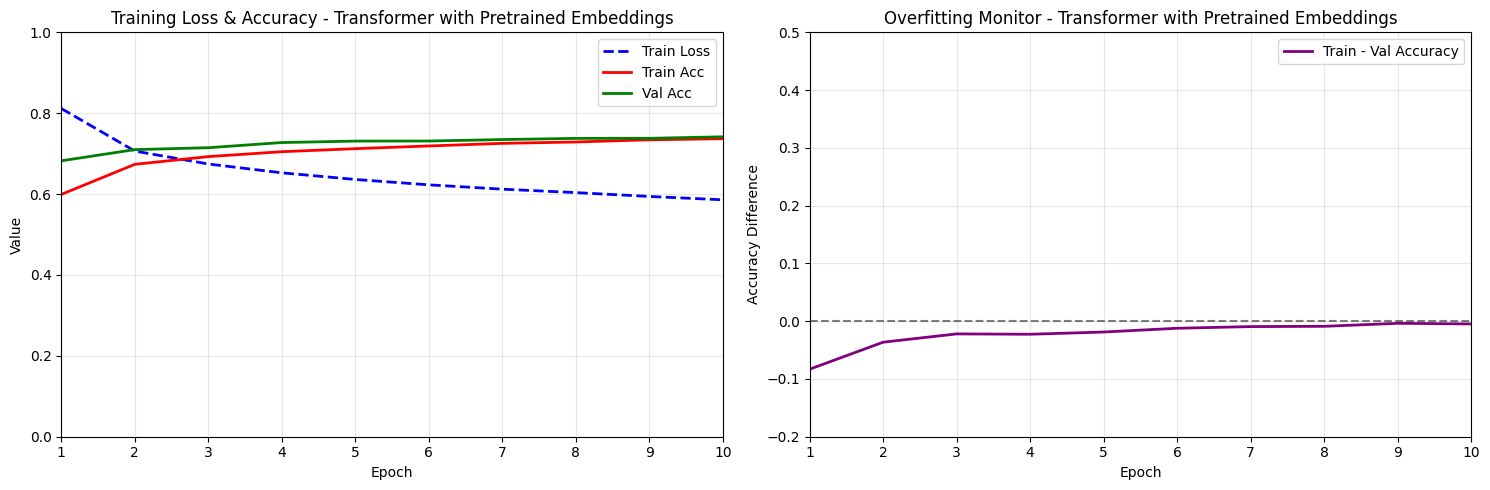


TRAINING SUMMARY
Model Name: Transformer with Pretrained Embeddings with Pretrained Embeddings
Final Train Loss: 0.5859
Final Train Accuracy: 0.7369
Final Val Loss: 0.6025
Final Val Accuracy: 0.7417
Best Val Accuracy: 0.7417 (Epoch 10)
Final Overfitting Gap: -0.0048


In [7]:
# 绘制训练曲线
plot_training_curves("Transformer with Pretrained Embeddings", transformer_history)

# 打印训练摘要
print_training_summary("Transformer with Pretrained Embeddings with Pretrained Embeddings", transformer_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


TEST RESULTS
Model Name: Transformer with Pretrained Embeddings
Test Accuracy: 0.7405
Test Precision (weighted): 0.7385
Test Recall (weighted): 0.7405
Test F1 Score (weighted): 0.7366

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7185    0.8055    0.7595     18608
     Neutral     0.6947    0.5538    0.6163     14723
    Positive     0.7790    0.8016    0.7901     25155

    accuracy                         0.7405     58486
   macro avg     0.7307    0.7203    0.7220     58486
weighted avg     0.7385    0.7405    0.7366     58486



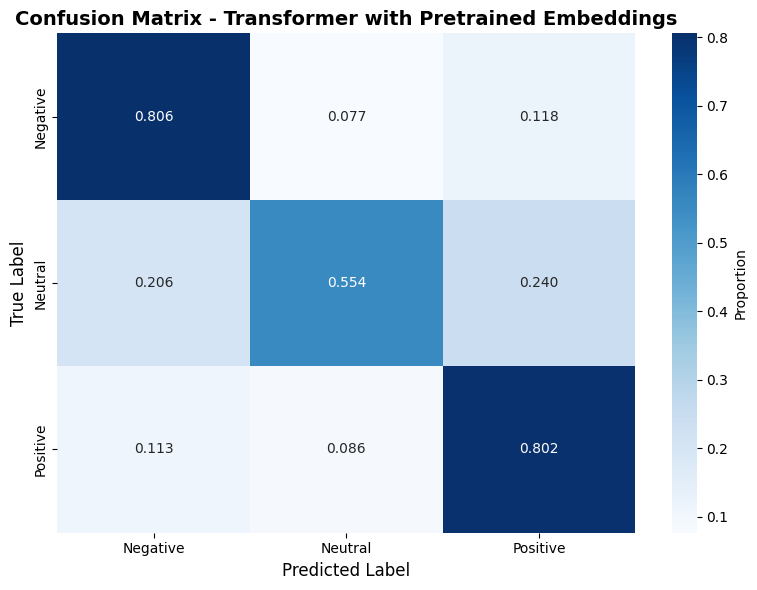


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7185, Recall=0.8055, F1=0.7595, Support=18608
 Neutral: Precision=0.6947, Recall=0.5538, F1=0.6163, Support=14723
Positive: Precision=0.7790, Recall=0.8016, F1=0.7901, Support=25155


In [8]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    test_loader=test_data_loader_trans,
    device=device
)

In [9]:
# 保存Transformer训练结果
save_training_results(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=transformer_history,
    test_results=transformer_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: Transformer with Pretrained Embeddings (Transformer)
  - 实际训练轮数: 10
  - 测试准确率: 0.7405
  - 测试F1分数: 0.7366
  - 记录时间: 2025-11-26 17:24:56
  - 总记录数: 59
